# Double pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

* Last revised 17-Mar-2019 by Dick Furnstahl (furnstahl.1@osu.edu).
* Last revised 20-Apr-2022 by Leo Deer (deer.279@osu.edu).

## Equations of Motion 

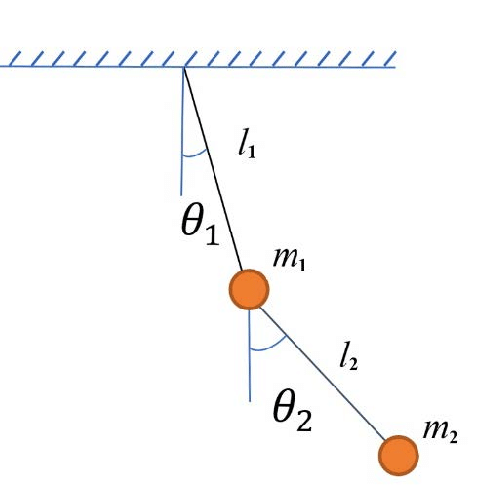

For this double pendulum, we will use the Lagrangian formulation with generalized coordinates $\theta_1$ & $\theta_2$. From this we find our lagragian,

$\begin{align}
  \mathcal{L} = \frac12 (m_1 + m_2) l_1^2 \dot\theta_1^2  + \frac12 m_2 l_2^2 \dot\theta_2^2 + m_2 l_1 l_2 \cos(\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2 + g (m_1 + m_2) l_1 \cos(\theta_1) + g m_2 l_2 \cos(\theta_2)
\end{align}$

Once we apply the euler lagrange equations for our two coordinates, we obtain,

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\theta_1} = \frac{\partial\mathcal L}{\partial\theta_1}
 \quad\Longrightarrow\quad
 -g (m_1 + m_2) \sin\theta_1 = (m_1 + m_2) l_1 \ddot\theta_1 + m_2 l_2 \sin(\theta_1 - \theta_2) \dot\theta_2^2 + m_2 l_2 \cos(\theta_1 - \theta_2) \ddot\theta_2
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\theta_2} = \frac{\partial\mathcal L}{\partial\theta_2}
 \quad\Longrightarrow\quad
 -g \sin\theta_2 = l_2 \ddot\theta_2 + l_1 \sin(\theta_2 - \theta_1) \dot\theta_1^2 + l_1 \cos(\theta_2 - \theta_1) \ddot\theta_1
    \;.
\end{align}$

From these we may solve for $\ddot\theta_1$ & $\ddot\theta_2$ to find our equations of motion
$\begin{align}
 \ddot\theta_1 = \frac{g m_2 \cos(\theta_1 - \theta_2) \sin\theta_2 - m_2 l_1 \cos(\theta_1 - \theta_2) \sin(\theta_1 - \theta_2) \dot\theta_1^2 - m_2 l_2 \sin(\theta_1 - \theta_2) \dot\theta_2^2 - g (m_1 + m_2) \sin\theta_1}{(m_1 + m_2) l_1 - m_2 l_1 \cos(\theta_1 - \theta_2)^2}
\end{align}$

$\begin{align}
 \ddot\theta_2 = \frac{g (m_1 + m_2) \cos(\theta_2 - \theta_1) \sin\theta_1 - m_2 l_2 \cos(\theta_2 - \theta_1) \sin(\theta_2 - \theta_1) \dot\theta_2^2 - (m_1 + m_2) l_1 \sin(\theta_2 - \theta_1) \dot\theta_1^2 - g (m_1 + m_2) \sin\theta_2}{(m_1 + m_2) l_2 - m_2 l_2 \cos(\theta_2 - \theta_1)^2}
\end{align}$

These are two coupled $2^{nd}$ order equations, but we may rewrite them as $4$ $1^{st}$ order equations by introducing $\omega_1 = \dot\theta_1$ & $\omega_2 = \dot\theta_2$ which gives

$\begin{align}
 \dot\omega_1 = \frac{g m_2 \cos(\theta_1 - \theta_2) \sin\theta_2 - m_2 l_1 \cos(\theta_1 - \theta_2) \sin(\theta_1 - \theta_2) \omega_1^2 - m_2 l_2 \sin(\theta_1 - \theta_2) \omega_2^2 - g (m_1 + m_2) \sin\theta_1}{(m_1 + m_2) l_1 - m_2 l_1 \cos(\theta_1 - \theta_2)^2}
\end{align}$

$\begin{align}
 \dot\theta_1 = \omega_1
\end{align}$

$\begin{align}
 \dot\omega_2 = \frac{g (m_1 + m_2) \cos(\theta_2 - \theta_1) \sin\theta_1 - m_2 l_2 \cos(\theta_2 - \theta_1) \sin(\theta_2 - \theta_1) \omega_2^2 - (m_1 + m_2) l_1 \sin(\theta_2 - \theta_1) \omega_1^2 - g (m_1 + m_2) \sin\theta_2}{(m_1 + m_2) l_2 - m_2 l_2 \cos(\theta_2 - \theta_1)^2}
\end{align}$

$\begin{align}
 \dot\theta_2 = \omega_2
\end{align}$

These are what we shall solve.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Double pendulum class and utility functions

In [4]:
class LagrangianDPendulum():
    """
    Double Pendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
         length of the first pendulum
    L2 : float
         length of the second pendulum
    m1 : float
         mass of the first pendulum
    m2 : float
         mass of the second pendulum
    g : float
        gravitational acceleration at the earth's surface

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    
    solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
        Solves the differential equations for theta1 and theta2 given the
        initial conditions     
    """
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 2-component vector with y[0] = phi1(t) and y[1] = dphi1/dt
                                      y[2] = phi2(t) and y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        c = np.cos(y[0]-y[2])
        s = np.sin(y[2]-y[0])
        denom = ((self.m1 + self.m2) - self.m2 * ((c)**2.))
        theta1, theta1_dot, theta2, theta2_dot = y
        
        return [y[1], (self.m2 * self.L1 * c * s * (theta1_dot**2.) \
                       + self.m2 * self.L2 * s * (theta2_dot**2.) \
                       - self.g * (self.m1 + self.m2) * np.sin(theta1) \
                       + self.g * self.m2 * c * np.sin(theta2))/ \
                    (self.L1 * denom), 
                y[3], (self.g * (self.m1 + self.m2) * c * np.sin(theta1) \
                       - self.m2 * self.L2 * c * s * (theta2_dot**2.) \
                       - (self.m1 + self.m2) * self.L1 * s * (theta1_dot**2) \
                       - self.g * (self.m1 + self.m2) * np.sin(theta2))/ \
                    (self.L2 * denom)]
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta1, theta1_dot, theta2, theta2_dot = solution.y
    
        return theta1, theta1_dot, theta2, theta2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple plots 

In [7]:
# Labels for individual plot axes
theta1_vs_time_labels = (r'$t$', r'$\theta_1(t)$')
theta2_vs_time_labels = (r'$t$', r'$\theta_2(t)$')
theta1_dot_vs_time_labels = (r'$t$', r'$d\theta_1/dt(t)$')
theta2_dot_vs_time_labels = (r'$t$', r'$d\theta_2/dt(t)$')
state_space1_labels = (r'$\theta_1$', r'$d\theta_1/dt$')
state_space2_labels = (r'$\theta_2$', r'$d\theta_2/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 500. #largest time value of simulation
t_stop = 50. #largest time value on plots
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
p1 = LagrangianDPendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


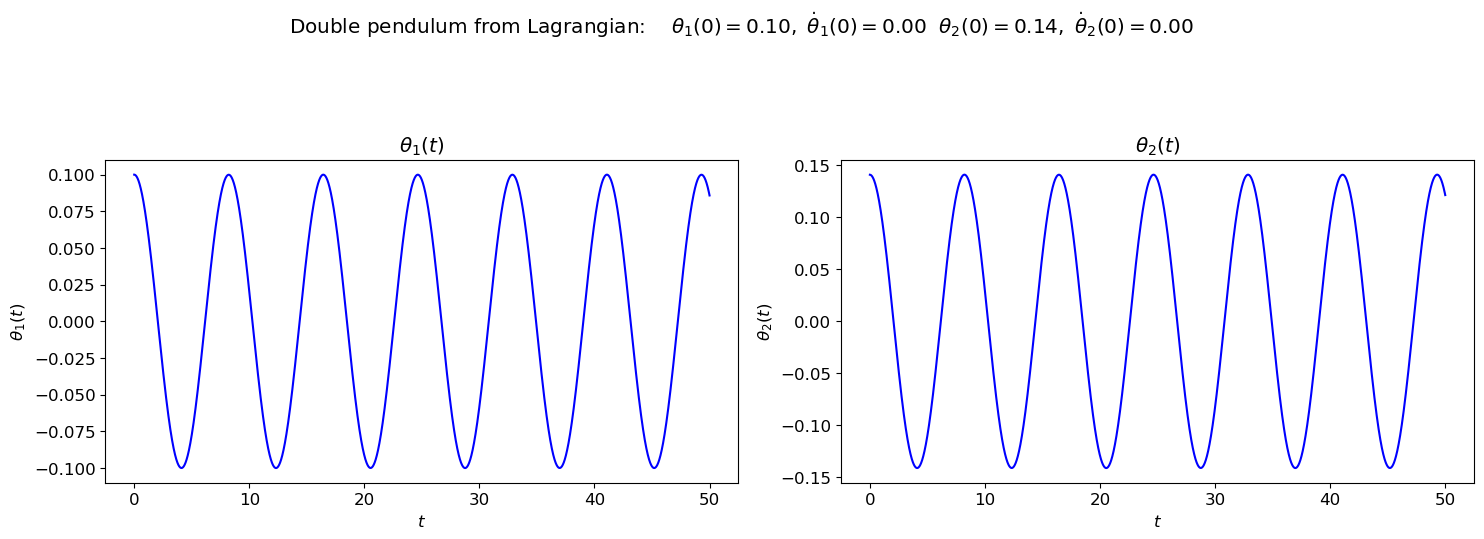

In [8]:
# both plots: same initial conditions
theta1_0 = 0.1
theta2_0 = 0.141
theta1_dot_0 = 0.
theta2_dot_0 = 0.
theta1, theta1_dot, theta2, theta2_dot = p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f}$' + \
                rf'  $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_stop)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\theta_1(t)$', 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_stop)    
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            axis_labels=theta2_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\theta_2(t)$', 
            ax=ax_b)    

fig.tight_layout()
#fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

## AnimationPendulumPlot class

In [9]:
class AnimationPendulumPlot(LagrangianDPendulum):
    """
    AnimationPlot class uses matplotlib.animation.FuncAnimation to animate
     the dynamics of an oscillator.  This includes a simple time dependence
     graph, a state space graph with Poincare map, and a physical model.
     
     We'll start with a pendulum and then generalize later.
     
    Parameters
    ----------
    theta1_vs_t : boolean
        If True, plot theta1(t) vs. t
        
    theta2_vs_t : boolean
        If True, plot theta2(t) vs. t
    
    theta1_dot_vs_t : boolean
        If True, plot theta1_dot(t) vs. t
        
    theta2_dot_vs_t : boolean
        If True, plot theta2_dot(t) vs. t
    
    state_space1 : boolean
        If True, plot theta1_dot(t) s. theta1(t)
        
    state_space2 : boolean
        If True, plot theta2_dot(t) s. theta2(t)
    
    physics_pend : boolean
        If True, draw the pendulum at theta1(t) & theta2(t) vs. t


    Methods
    -------
    plot_setup
    
    t_pts_init
    
    add_pendulum
    
    animate_pendulum
    
    plot_setup
    
    start_animation
    """
    def __init__(self, theta1_vs_t=True, theta2_vs_t=True,
                 theta1_dot_vs_t=False, theta2_dot_vs_t=False,
                 state_space1=True, state_space2=True,
                 physical_pend=True):
        LagrangianDPendulum.__init__(self, L1, L2, m1, m2, g)
        self.theta1_list = []
        self.theta2_list = []
        self.theta1_dot_list = []
        self.theta2_dot_list = []
        self.length1 = 0.8
        self.length2 = 0.8
        self.line_colors = ['blue', 'red']
        self.pt_colors = ['black', 'brown']
        self.phi_align = ['left', 'right']
                  
    def t_pts_init(self, t_start=0., t_end=100., delta_t=0.01): 
        """Create the array of time points for the full iteration"""
        self.t_start = t_start
        self.t_end = t_end
        self.delta_t = delta_t
        self.t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    def add_pendulum(self, pend, theta1_0=0., theta2_0=0., theta1_dot_0=0., theta2_dot_0=0.):
        """Adds pendulums to be plotted as a class instance of Pendulum
            along with initial conditions.  So it knows all of the parameters
            as well through the Pendulum class.
        """
        self.pend = pend
        theta1, theta1_dot, theta2, theta2_dot = p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
        self.theta1_list.append(theta1)
        self.theta2_list.append(theta2)
        self.theta1_dot_list.append(theta1_dot)
        self.theta2_dot_list.append(theta2_dot)
    
    def plot_setup(self, plot_start, plot_end):
        """Set up the plots to be displayed. """

            # start the plot!
#         overall_title = 'Parameters:  ' + \
#                         rf' $\omega = {omega_ext:.2f},$' + \
#                         rf' $\gamma = {gamma_ext:.3f},$' + \
#                         rf' $\omega_0 = {omega_0:.2f},$' + \
#                         rf' $\beta = {beta:.2f},$' + \
#                         rf'  $\phi_0 = {phi_0:.2f},$' + \
#                         rf' $\dot\phi_0 = {phi_dot_0:.2f}$' + \
#                         '\n'     # \n means a new line (adds some space here)
#         self.fig = plt.figure(figsize=(10,3.3), num='Pendulum Plots')
#         self.fig.suptitle(overall_title, va='top')

        # Labels for individual plot axes
        theta1_vs_time_labels = (r'$t$', r'$\theta_1(t)$')
        theta2_vs_time_labels = (r'$t$', r'$\theta_2(t)$')
        theta1_dot_vs_time_labels = (r'$t$', r'$d\theta_1/dt(t)$')
        theta2_dot_vs_time_labels = (r'$t$', r'$d\theta_2/dt(t)$')
        state_space1_labels = (r'$\theta_1$', r'$d\theta_1/dt$')
        state_space2_labels = (r'$\theta_2$', r'$d\theta_2/dt$')
        
        self.fig = plt.figure(figsize=(10, 3.3), num='Pendulum animation')

        self.ax_1 = self.fig.add_subplot(2,3,1)        
        self.ax_1.set_xlabel(r'$t$')
        self.ax_1.set_ylabel(r'$\theta_1(t)$')
        self.line_1 = []
        self.pt_1 = []
        
        self.ax_4 = self.fig.add_subplot(2,3,4)        
        self.ax_4.set_xlabel(r'$t$')
        self.ax_4.set_ylabel(r'$\theta_2(t)$')
        self.line_4 = []
        self.pt_4 = []

        self.ax_2 = self.fig.add_subplot(2,3,2, projection='polar')
        self.ax_2.set_aspect(1)   # aspect ratio 1 subplot
        self.ax_2.set_rorigin(0.)   # origin in the middle
        self.ax_2.set_theta_zero_location('S')  # phi=0 at the bottom
        self.ax_2.set_ylim(-1.,1.)  # r goes from 0 to 1
        self.ax_2.grid(False)   # no longitude/lattitude lines
        self.ax_2.set_xticklabels([])   # turn off angle labels
        self.ax_2.set_yticklabels([])    # turn off radial labels
        self.ax_2.spines['polar'].set_visible(False) # no circular border
        self.line_2 = []
        self.pt_2 = []
        self.phi_text = []

        self.ax_3 = self.fig.add_subplot(2,3,3)
        self.ax_3.set_xlabel(r'$\theta_1$')
        self.ax_3.set_ylabel(r'$\dot\theta_1$')
        self.line_3 = []
        self.pt_3 = []
        
        self.ax_5 = self.fig.add_subplot(2,3,6)
        self.ax_5.set_xlabel(r'$\theta_2$')
        self.ax_5.set_ylabel(r'$\dot\theta_2$')
        self.line_5 = []
        self.pt_5 = []
       
 ################################################ Left Off Here ###############################################       
        # plot new arrays from start to stop
        self.start, self.stop = start_stop_indices(self.t_pts, plot_start, 
                                                   plot_end)
        self.t_pts_plt = self.t_pts[self.start : self.stop]
        self.theta1_plt_list = []
        self.theta2_plt_list = []
        self.theta1_dot_plt_list = []
        self.theta2_dot_plt_list = []
        for i, (theta1, theta2, theta1_dot, theta2_dot) in enumerate(zip(self.theta1_plt_list,\
                self.theta2_plt_list, self.theta1_dot_plt_list, self.theta2_dot_plt_list)):
            theta1_plt = theta1[self.start : self.stop]
            theta2_plt = theta2[self.start : self.stop]
            self.theta1_plt_list.append(theta1_plt)
            self.theta2_plt_list.append(theta2_plt)
            
            theta1_dot_plt = theta1_dot[self.start : self.stop]
            theta2_dot_plt = theta2_dot[self.start : self.stop]
            self.theta1_dot_plt_list.append(theta1_dot_plt)
            self.theta2_dot_plt_list.append(theta2_dot_plt)

            line_1, = self.ax_1.plot(self.t_pts_plt, theta1_plt, 
                                      color=self.line_colors[i])
            self.line_1.append(line_1)
            pt_1, = self.ax_1.plot(self.t_pts_plt[0], theta1_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_1.append(pt_1)
            
            line_2, = self.ax_2.plot(self.t_pts_plt, theta2_plt, 
                                      color=self.line_colors[i])
            self.line_2.append(line_2)
            pt_2, = self.ax_2.plot(self.t_pts_plt[0], theta2_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_2.append(pt_2)
        
            self.ax_3.plot(0, 0, color='black', marker='o', markersize=5)
            line_3, = self.ax_3.plot([theta1_plt[0], theta1_plt[0]], 
                                      [0.,self.length], 
                                      color=self.line_colors[i], lw=3)
            self.line_3.append(line_3)
            pt_3, = self.ax_3.plot(theta1_plt[0], self.length, 
                                   marker='o', markersize=15, 
                                   color=self.pt_colors[i])
            self.pt_3.append(pt_3)
            theta1_string = rf'$\theta_1 = {theta1_plt[0]: .1f}$'
            theta1_text = self.ax_2.text(np.pi, 1., theta1_string, 
                                   horizontalalignment=self.theta1_align[i]) 
            self.theta1_text.append(theta1_text)        
            
            self.ax_4.plot(0, 0, color='black', marker='o', markersize=5)
            line_4, = self.ax_4.plot([theta2_plt[0], theta2_plt[0]], 
                                      [0.,self.length], 
                                      color=self.line_colors[i], lw=3)
            self.line_4.append(line_3)
            pt_4, = self.ax_4.plot(theta2_plt[0], self.length, 
                                   marker='o', markersize=15, 
                                   color=self.pt_colors[i])
            self.pt_4.append(pt_4)
            theta2_string = rf'$\theta_2 = {theta2_plt[0]: .1f}$'
            theta2_text = self.ax_4.text(np.pi, 1., theta2_string, 
                                   horizontalalignment=self.theta2_align[i]) 
            self.theta2_text.append(theta2_text)   
        
            line_5, = self.ax_5.plot(theta1_plt, theta1_dot_plt, 
                                     color=self.line_colors[i])
            self.line_5.append(line_5)
            pt_5, = self.ax_5.plot(theta1_plt[0], theta1_dot_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_5.append(pt_5)
            
            line_6, = self.ax_6.plot(theta2_plt, theta2_dot_plt, 
                                     color=self.line_colors[i])
            self.line_6.append(line_6)
            pt_6, = self.ax_6.plot(theta2_plt[0], theta2_dot_plt[0], 
                                    'o', color=self.pt_colors[i])
            self.pt_6.append(pt_6)
        
        
        self.fig.tight_layout()
        

    def animate_pendulum(self, i, t_pts_skip, theta1_skip_list, theta2_skip_list,
                         theta1_dot_skip_list, theta2_dot_skip_list):
        for index, (theta1_skip, theta2_skip, theta1_dot_skip, theta2_dot_skip) in \
                     enumerate(zip(theta1_skip_list, theta2_skip_list,
                         theta1_dot_skip_list, theta2_dot_skip_list)):
            self.pt_1[index].set_data(t_pts_skip[i], theta1_skip[i])
            self.pt_2[index].set_data(t_pts_skip[i], theta2_skip[i])

            self.line_3[index].set_data([theta1_skip[i], theta1_skip[i]], 
                                        [0., self.length])
            self.pt_3[index].set_data(theta1_skip[i], self.length)
            theta1_string = rf'$\theta_1 = {theta1_skip[i]: .1f}$  '
            self.theta1_text[index].set_text(theta1_string)
            self.line_4[index].set_data([theta2_skip[i], theta2_skip[i]], 
                                        [0., self.length])
            self.pt_4[index].set_data(theta2_skip[i], self.length)
            theta2_string = rf'$\theta_2 = {theta2_skip[i]: .1f}$  '
            self.theta2_text[index].set_text(theta2_string)

            self.pt_5[index].set_data(theta1_skip[i], theta1_dot_skip[i])
            self.pt_6[index].set_data(theta2_skip[i], theta2_dot_skip[i])

        #return self.pt_1, self.pt_2, self.phi_text, self.pt_3
          
        
    def start_animation(self, skip=2, interval=25.):
        self.skip = skip          # skip between points in t_pts array
        self.interval = interval  # time between frames in milliseconds
        
        theta1_skip_list = []
        theta2_skip_list = []
        theta1_dot_skip_list = []
        theta2_dot_skip_list = []
        for i, (theta1_plt, theta2_plt, theta1_dot_plt, theta2_dot_plt) in enumerate(zip(self.theta1_plt_list, 
                                                       self.theta2_plt_list, self.theta1_dot_plt_list, self.theta2_dot_plt_list)):
            theta1_skip_list.append(theta1_plt[::self.skip])
            theta2_skip_list.append(theta2_plt[::self.skip])
            theta1_dot_skip_list.append(theta1_dot_plt[::self.skip])
            theta2_dot_skip_list.append(theta2_dot_plt[::self.skip])
                      
        t_pts_skip = self.t_pts_plt[::self.skip]                                   
        self.anim = animation.FuncAnimation(self.fig, self.animate_pendulum, 
                           fargs=(t_pts_skip,
                                  theta1_skip_list, theta2_skip_list, 
                                  theta1_dot_skip_list, theta2_dot_skip_list
                                 ), 
                           init_func=None,
                           frames=len(t_pts_skip), 
                           interval=self.interval, 
                           blit=False, repeat=False,
                           save_count=0)

        #HTML(anim.to_jshtml())
        self.fig.show()

In [10]:
# Create a pendulum animation instance. 
pendulum_anim = AnimationPendulumPlot(theta1_vs_t=True, 
                                      theta2_vs_t=True,
                                      theta1_dot_vs_t=False, 
                                      theta2_dot_vs_t=False,
                                      state_space1=True, 
                                      state_space2=True,
                                      physical_pend=True)

# Common plotting time (generate the full time here then use slices below)
t_start = 0.
t_end = 100.
delta_t = 0.01
pendulum_anim.t_pts_init(t_start, t_end, delta_t)

#Pendulum Parameters
L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
p1 = LagrangianDPendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)

# Initial conditions specified
theta1_0 = np.pi/2
theta2_0 = 0.
theta1_dot_0 = 0.
theta2_dot_0 = 0.

# Add a pendulum to the animation plots; this solves the differential
#  equation for the full t_pts array, generating phi and phi_dot internally. 
pendulum_anim.add_pendulum(p1, theta1_0, theta2_0, theta1_dot_0, theta2_dot_0)

/var/folders/7c/ctd744mx4bjchcjkw9s71m1r0000gn/T/ipykernel_85407/436758380.py:277: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


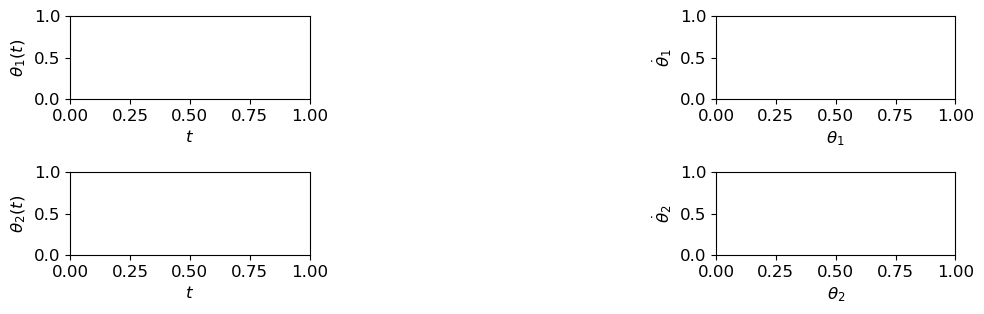

In [11]:
plot_start = 0.   # time to begin plotting
plot_end = 30.    # time to end plotting
pendulum_anim.plot_setup(plot_start, plot_end)

# Start the animation (adjust skip and interval for a smooth plot at a 
#  useful speed)
skip = 2        # skip between time points (in units of delta_t) 
interval = 15.  # time between frames in milliseconds
pendulum_anim.start_animation(skip, interval)

## Investigations into Chaos

### Power Spectrum
First we must rerun the simulations large inital conditions which will lead to chaotic behavior.

In [12]:
theta1_0 = np.pi
theta2_0 = np.pi/2.
theta1_dot_0 = 0.
theta2_dot_0 = 0.
theta1c, theta1_dotc, theta2c, theta2_dotc = p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

Text(0.5, 1.0, 'Power Spectrum for $\\theta_2$')

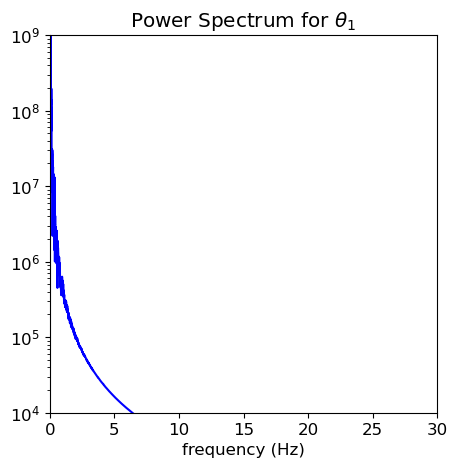

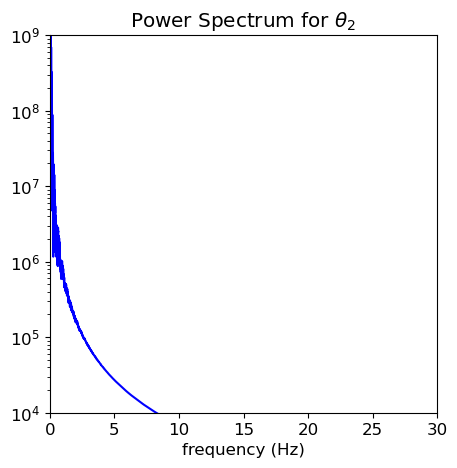

In [13]:
start, stop = start_stop_indices(t_pts, 20., t_end)    
signal1 = theta1c[start:stop]
power_spectrum1 = np.abs(np.fft.fft(signal1))**2
freqs1 = 2.*np.pi * np.fft.fftfreq(signal1.size, delta_t)
idx1 = np.argsort(freqs1)

signal2 = theta2c[start:stop]
power_spectrum2 = np.abs(np.fft.fft(signal2))**2
freqs2 = 2.*np.pi * np.fft.fftfreq(signal2.size, delta_t)
idx2 = np.argsort(freqs2)

fig_ps1 = plt.figure(figsize=(5,5))
ax_ps1 = fig_ps1.add_subplot(1,1,1)
ax_ps1.semilogy(freqs1[idx1], power_spectrum1[idx1], color='blue')
ax_ps1.set_xlim(0, 30.)
ax_ps1.set_ylim(1.e4, 1.e9)
ax_ps1.set_xlabel('frequency (Hz)')
ax_ps1.set_title('Power Spectrum for' + rf' $\theta_1$')

fig_ps2 = plt.figure(figsize=(5,5))
ax_ps2 = fig_ps2.add_subplot(1,1,1)
ax_ps2.semilogy(freqs2[idx2], power_spectrum2[idx2], color='blue')
ax_ps2.set_xlim(0, 30.)
ax_ps2.set_ylim(1.e4, 1.e9)
ax_ps2.set_xlabel('frequency (Hz)')
ax_ps2.set_title('Power Spectrum for' + rf' $\theta_2$')

#fig_ps.tight_layout()

We see that both angles have a continuous power spectrum which is a marker of chaotic motion

### $\Delta\theta$ Plots
We will start with two double pendulums with nearly identical initial conditions

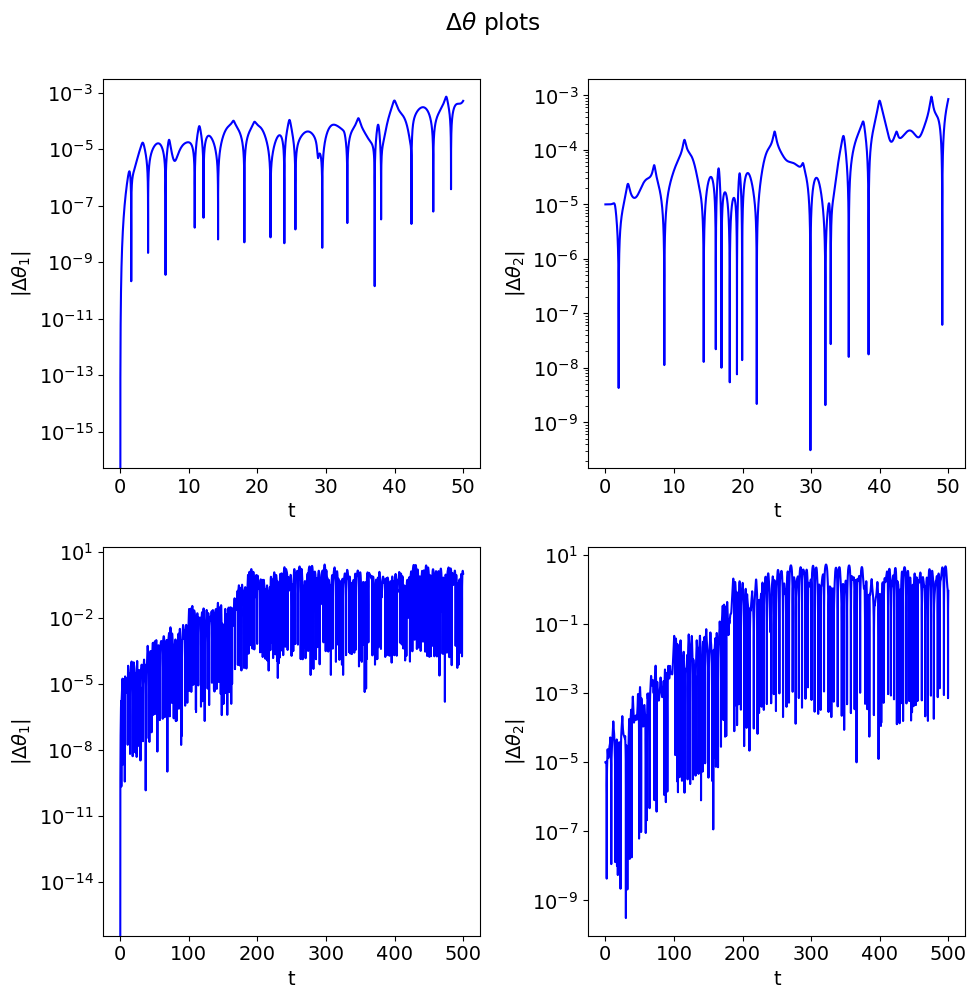

In [14]:
theta1_0_1 = np.pi/2.
theta2_0_1 = 0.
theta1_dot_0_1 = 0.
theta2_dot_0_1 = 0.
theta1_1, theta1_dot_1, theta2_1, theta2_dot_1 = p1.solve_ode(t_pts, theta1_0_1, theta1_dot_0_1, theta2_0_1, theta2_dot_0_1)

theta1_0_2 = np.pi/2.
theta2_0_2 = 0.00001 # this dictates the difference in the initial conditions
theta1_dot_0_2 = 0.
theta2_dot_0_2 = 0.
theta1_2, theta1_dot_2, theta2_2, theta2_dot_2 = p1.solve_ode(t_pts, theta1_0_2, theta1_dot_0_2, theta2_0_2, theta2_dot_0_2)

# Calculate the absolute difference in theta1
Delta_theta1 = np.fabs(theta1_2 - theta1_1)

# Calculate the absolute difference in theta2
Delta_theta2 = np.fabs(theta2_2 - theta2_1)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = rf' $\Delta\theta$ plots'
fig.suptitle(overall_title, va='baseline')
    
# two plot: plot from t=0 to t=8 and another from t=0 to t=100 
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 50.)
ax_a.semilogy(t_pts[start : stop], Delta_theta1[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\theta_1|$')

ax_b = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 50.)
plot_y_vs_x(t_pts[start : stop], Delta_theta2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\theta_2|$')

ax_c = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, 0., 500.)
ax_c.semilogy(t_pts[start : stop], Delta_theta1[start : stop], 
            color='blue', label=None)    
ax_c.set_xlabel('t')
ax_c.set_ylabel(r'$|\Delta\theta_1|$')

ax_d = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, 0., 500.)
plot_y_vs_x(t_pts[start : stop], Delta_theta2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_d.set_xlabel('t')
ax_d.set_ylabel(r'$|\Delta\theta_2|$')
                              
fig.tight_layout()
# always bbox_inches='tight' for best results.  Further adjustments also.
#fig.savefig('figure_12.11.png', bbox_inches='tight')  

We see that both $\Delta\theta_1$ and $\Delta\theta_2$ grow linearly on this semilog plot. This indicates that $\Delta\theta_1$ and $\Delta\theta_2$ both have a positive Lyopunov exponent, a characteristic of chaos.